# Figures for intra cell type variation that translates to spatial data

Show intra cell type variation of specific genes in the intra lobar sample. We're looking at genes with high PCA score not only due to cell type variation.


In [9]:
from pathlib import Path
from itertools import combinations
from tifffile import imread
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
from skimage.measure import label

import matplotlib.pyplot as plt


# Load SCRINSHOT intra lobar data including image

In [10]:
df = pd.read_excel(
    '/Users/louis.kuemmerle/Promotion/projects/G1/code/revisions/data/spapros_suppl_tables/A4_SCRINSHOT_data.xlsx', 
    sheet_name='intra-lobar count data',
    index_col=0
)
df = df.sort_values("Cell")


In [11]:
adata_scrins = sc.AnnData(
    X = df.iloc[:,3:-1].values,
    obs = df[["Cell","roi","Area","celltype"]],
    var = pd.DataFrame(index=df.columns[3:-1])
)

# normalize by area
adata_scrins.obs["Area"] = adata_scrins.obs["Area"].astype(float)
adata_scrins.X = adata_scrins.X / adata_scrins.obs["Area"].values.reshape(-1,1)
sc.pp.log1p(adata_scrins)

#adata_scrins = adata_scrins[:,adata_scrins.var_names.isin(adata.var_names)]

/Users/louis.kuemmerle/opt/anaconda3/envs/g1_rev/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
celltype_sc_to_scrins = {
    'Basal'               :'Basal',
    'Club'                :'Club',
    'Goblet'              :None,
    'Duct SMG'            :None,
    'Mucous SMG'          :None,
    'Serous SMG'          :None,
    'Ciliated'            :'Multiciliated',
    'AT1'                 :None,
    'AT2'                 :'AT2',
    'Fibroblast'          :'Fibroblast',
    'Chondrocytes'        :None,
    'Mesothelial cell'    :None,
    'Muscle_cell'         :'Smooth muscle',
    'Blood_vessel'        :'Endothelial cell',
    'T_CD4'               :None,
    'T_CD8'               :None,
    'NK'                  :None,
    'B_cell'              :None,
    'Plasma_cell'         :None,
    'DC_plasmacytoid'     :None,
    'Lymphatic'           :None,
    'Lymphocyte'          :None,
    'Monocyte'            :None,
    'Macrophage'          :'Interstitial macrophages',
    'Macrophage_Dividing' :None,
    'DC1'                 :None,
    'DC2'                 :None,
    'Mast_cell'           :None,
}

/Users/louis.kuemmerle/opt/anaconda3/envs/g1_rev/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:771: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/Users/louis.kuemmerle/opt/anaconda3/envs/g1_rev/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/louis.kuemmerle/opt/anaconda3/envs/g1_rev/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/louis.kuemmerle/opt/ana

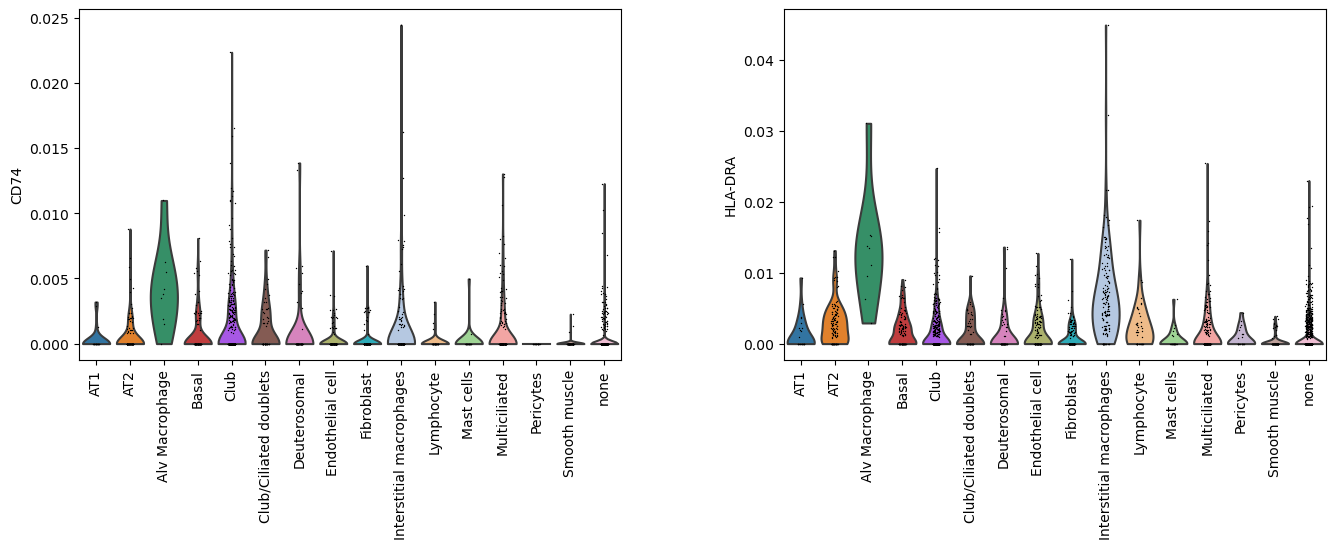

In [13]:
# just to create some colors for cell types
sc.pl.violin(adata_scrins, groupby="celltype", keys=["CD74","HLA-DRA"], rotation=90)

In [14]:
color_map_coarse = {
    'AT1'                              : "#00ffff", #cyan
    'AT2'                              : "#de2d26", #dark red
    'Club'                             : "#a50f15", #red
    'Club/Ciliated doublets'           : "#cc4c02", #dark orange
    'Multiciliated'                    : "#FF8C00", #orange
    'Deuterosomal'                     : "#756bb1", #light purple
    'Basal'                            : "#E2D5C0", #light brown white #13_3
    'Smooth muscle'                    : "#54278f", #purple
    'Pericytes'                        : "#FF00FF", #magenta
    'Fibroblast'                       : "#3182bd", #blue
    'Endothelial cell'                 : "#FFFF00", #yellow
    #'(Vascular) Endothelial cell'      : "#FFFF00", #yellow
    #'Cappillary (G) endothelial cell'  : "#664E00", #brown
    'Lymphocyte'                       : "#36BCAD", #turkis
    'Interstitial macrophages'         : "#a1d99b", #light green
    'Alv Macrophage'                   : "#31a354", #green
    'Mast cells'                       : "#006d2c", #dark green
    'none'                             : "#636363", #dark grey
}
for ct in color_map_coarse:
    idx = adata_scrins.obs["celltype"].cat.categories.tolist().index(ct)
    adata_scrins.uns["celltype_colors"][idx] = color_map_coarse[ct]

In [15]:
img = imread("/Users/louis.kuemmerle/Promotion/projects/G1/code/revisions/data/spapros_suppl_files/F1_cell_outlines_intra_lobar.tif")
labels = label(img)


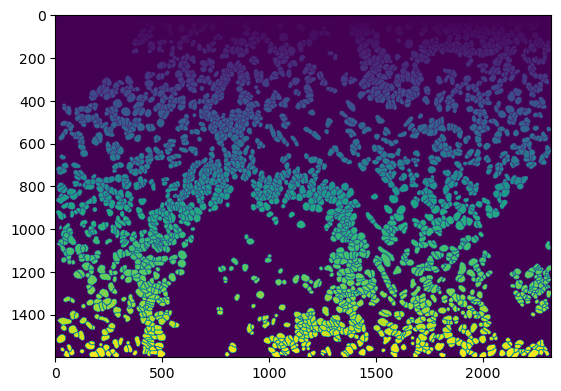

In [16]:
plt.imshow(labels)

In [35]:
def reduce_labels_to_celltypes(adata, labels, celltypes, ct_key="celltype"):
    """Get image with labels of cell types
    
    """
    cell_in_cts = adata.obs[ct_key].isin(celltypes)
    #set_to_zero = np.array([i+1 for i in range(mask) if not mask[i]])
    
    label_values = np.array([0] + [i+1 if in_cts else 0 for i, in_cts in enumerate(cell_in_cts)])
    
    masked_labels = label_values[labels]
    #masked_labels[masked_labels.isin(set_to_zero)] = 0
    
    return masked_labels

def get_colored_image_category(adata, labels, key="celltype"):
    """Get colored image from labels and category in adata.obs
    
    """
    # get color for each cell type
    color_dict = dict(zip(adata.obs[key].cat.categories, adata.uns[key+"_colors"]))
    # get color for each cell (cell 0 is background)
    colors = np.array(["#000000"] + [color_dict[c] for c in adata.obs[key]])
    # Convert hex to rgb
    colors_rgb = np.array([np.array([int(c[1:3],16), int(c[3:5],16), int(c[5:7],16)]) for c in colors])
    # get color for each pixel
    img_rgb = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=int)
    for i in range(3):
        img_rgb[:,:,i] = colors_rgb[:,i][labels]
    
    return img_rgb


def get_colored_image_gene(adata, labels, gene):
    """Color gene expression of cells in space 
    
    """
    # Get expression for each cell (cell 0 is background)
    expr = np.array([0] + np.array(adata[:,gene].X).flatten().tolist()) 
    # Map expr to pixels
    img = expr[labels]
    
    return img

def get_colored_image_gene_rank_norm(adata, labels, gene):
    """Color gene expression of cells in space 
    
    """
    # Get expression for each cell (cell 0 is background)
    expr = pd.Series(np.array(adata[:,gene].X).flatten()).rank(pct=True,method='dense').values.tolist()
    expr = np.array([0] + expr)
    # Map expr to pixels
    img = expr[labels]
    
    return img

In [76]:
#ct_to_genes = {
#    'Endothelial cell'         : ["IGFBP7", "RGCC", "CD74"], #, "HLA-DRA"], #"Blood_vessel"
#    'Interstitial macrophages' : ["APOE", "IFITM1", "CD74"], #, "HLA-DRA"], #"Macrophage"
#    "Fibroblast"               : ["MKI67", "PBK", "CD74"], #, "HLA-DRA"],
#    "AT2"                      : ["CD74", "HLA-DRA", "MKI67"], #, "PBK"],
#    'Multiciliated'            : ["CD74", "HLA-DRA", "MKI67"], #, "PBK"], #"Ciliated"
#}
ct_to_genes = {
    'Endothelial cell'         : ["IGFBP7", "RGCC"], #"CD74"], #, "HLA-DRA"], #"Blood_vessel"
    'Interstitial macrophages' : ["APOE", "IFITM1"], #"CD74"], #, "HLA-DRA"], #"Macrophage"
}

In [84]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 70
plt.rcParams['savefig.dpi'] = 200
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/louis.kuemmerle/opt/anaconda3/envs/g1_rev/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/louis.kuemmerle/opt/anaconda3/envs/g1_rev/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


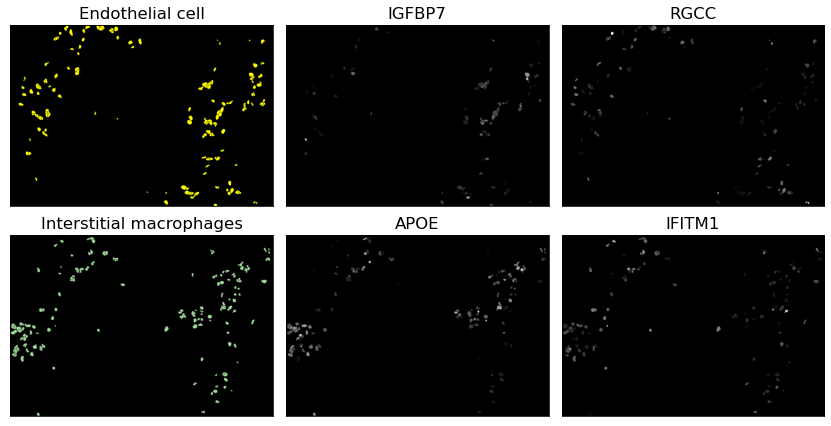

In [85]:
# Plot

nrows = len(ct_to_genes)
ncols = len(ct_to_genes['Endothelial cell']) + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3.8), sharex=True, sharey=True)

for i, ct in enumerate(ct_to_genes):
    masked_labels = reduce_labels_to_celltypes(adata_scrins, labels, [ct])
    img_ct_subset = get_colored_image_category(adata_scrins, masked_labels, key="celltype")
    
    axs[i,0].imshow(img_ct_subset)
    axs[i,0].set_title(ct)
    axs[i,0].set_xticks([])
    axs[i,0].set_yticks([])
    
    for j, gene in enumerate(ct_to_genes[ct]):        
        img_gene = get_colored_image_gene(adata_scrins, masked_labels, gene)
        axs[i,j+1].imshow(img_gene, cmap="binary_r")
        axs[i,j+1].set_title(gene)
        axs[i,j+1].set_xticks([])
        axs[i,j+1].set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig("./figures/3_5_intra_ct_variation.png", bbox_inches='tight')